In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import pandas as pd
import seaborn as sns

import pfjax as pf
from pfjax import proj_data, PGNETModel

key = random.PRNGKey(0)

# parameter values

theta = np.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1])
tau = np.array([1,1,1,1])*0.25
theta = np.append(theta, tau)
dt = .1
n_res = 1
n_obs = 50
pgnet_model = PGNETModel(dt, n_res)
key, subkey = random.split(key)

x_init = pgnet_model.init_sample(y_init=jnp.array([8., 8., 8., 5.]),
                     theta=jnp.append(theta[0:8], jnp.zeros(4)),
                     key=subkey)

y_meas, x_state = pf.simulate(pgnet_model, n_obs, x_init, theta, subkey)


Text(0.5, 1.0, 'Observations and Latent')

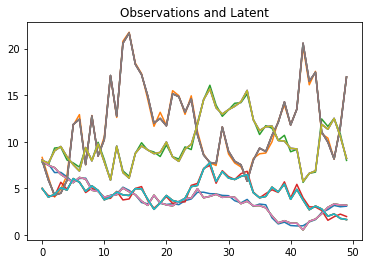

In [2]:
import matplotlib.pyplot as plt
plt.plot(y_meas[:, 0])
plt.plot(y_meas[:, 1])
plt.plot(y_meas[:, 2])
plt.plot(y_meas[:, 3])
plt.plot(np.exp(x_state[:,0]))
plt.plot(np.exp(x_state[:, 1]))
plt.plot(np.exp(x_state[:, 2]))
plt.plot(np.exp(x_state[:, 3]))
plt.title("Observations and Latent")

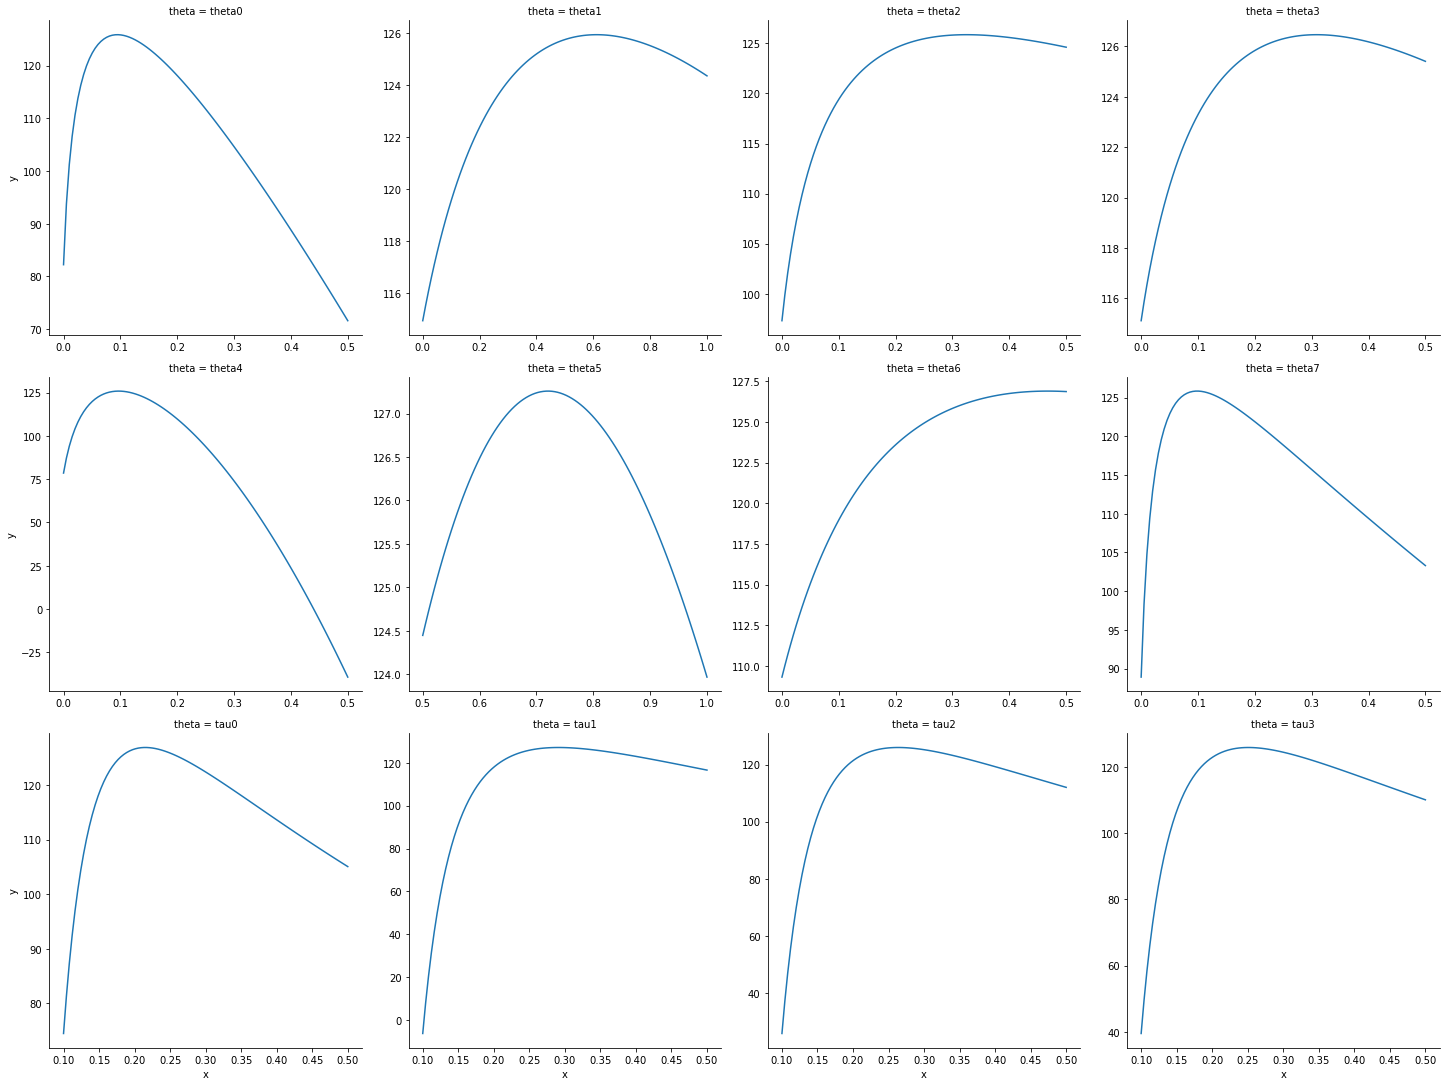

In [3]:
theta_lims = np.array([[0, 0.5], [0,1], [0, 0.5], [0, 0.5], [0, 0.5], [0.5, 1], [0, 0.5], [0, 0.5],
                     [.1, .5], [.1, .5], [.1, .5], [.1, .5]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]
n_pts = 100

# calculate projection plot


@jax.jit
def pgnet_loglik(theta):
    return pf.joint_loglik(model=pgnet_model, theta=theta, x_state=x_state, y_meas=y_meas)


plot_df = proj_data(pgnet_loglik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

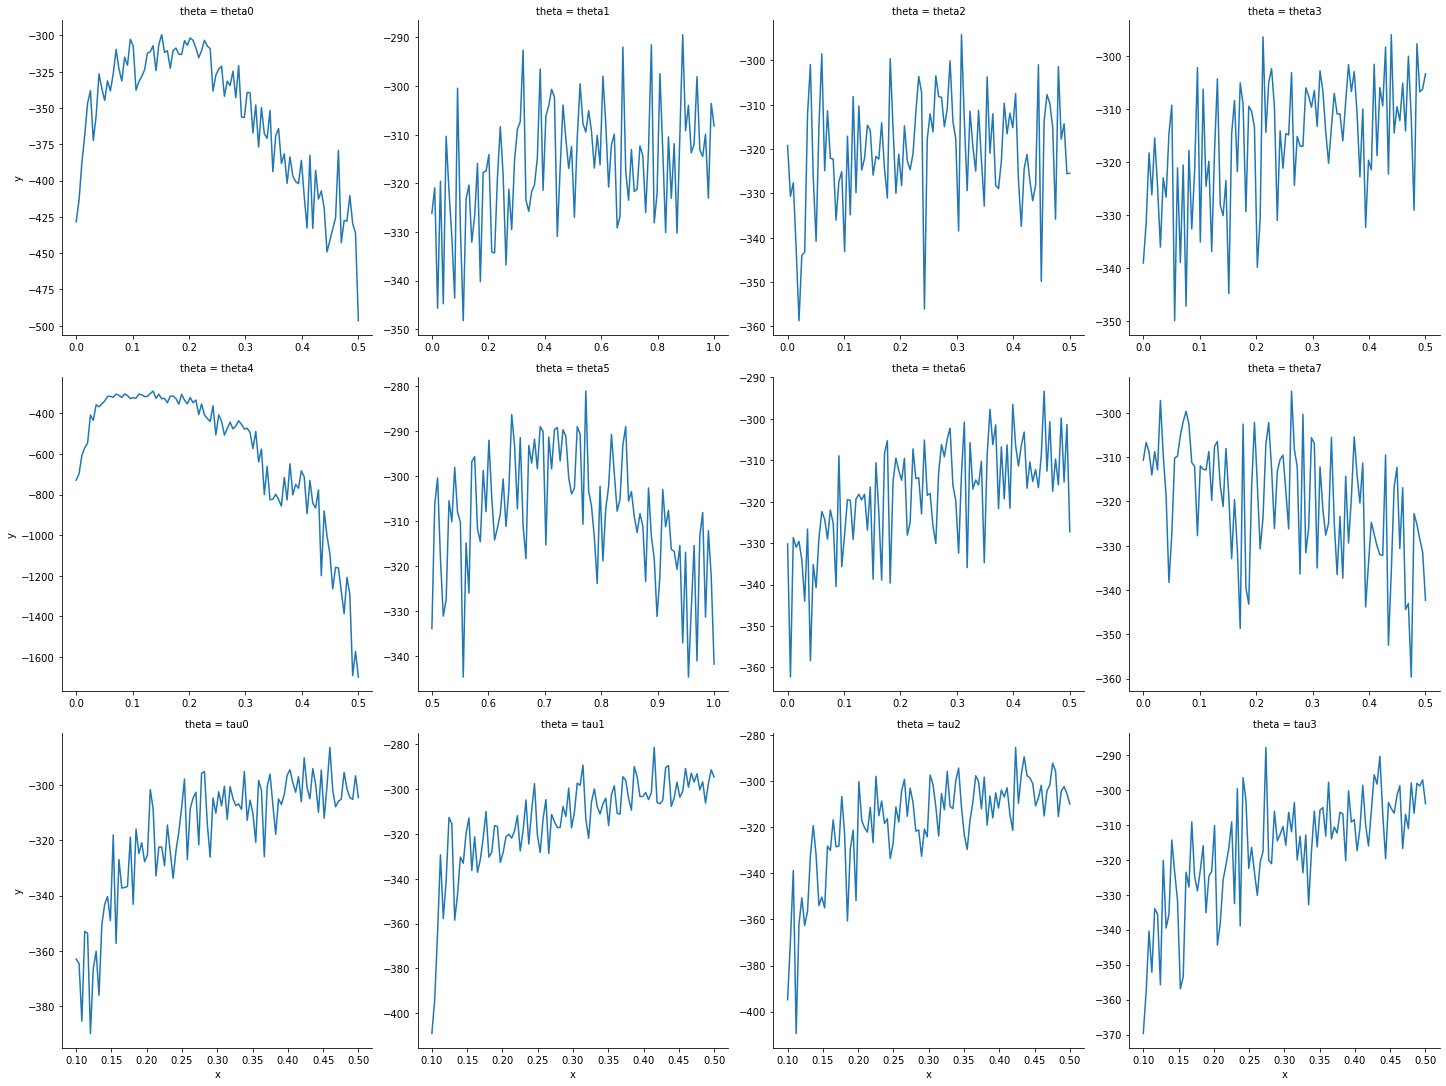

In [4]:
theta_lims = np.array([[0, 0.5], [0,1], [0, 0.5], [0, 0.5], [0, 0.5], [0.5, 1], [0, 0.5], [0, 0.5],
                     [.1, .5], [.1, .5], [.1, .5], [.1, .5]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]
n_pts = 100

# calculate projection plot
n_particles = 1000

@jax.jit
def pgnet_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=pgnet_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw_particles'])


plot_df = proj_data(pgnet_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)